# **Functions and Imports**

In [ ]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import RMSprop

import numpy as np
import random
import io
import math

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
main_url = '/content/drive/My Drive/DLWorkshop/ass3/home_depot_product_search_relevance/'

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
def draw_plots(history):
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Test Loss')
  plt.title('Model Loss (Mean Squared Error)')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_model(y_expected, y_actual, stage):
  print("Model MSE Loss in " + stage + " stage: " + str(mean_squared_error(y_expected, y_actual)))
  print("Model RMSE Loss in " + stage + " stage: " + str(math.sqrt(mean_squared_error(y_expected, y_actual))))
  print("Model MAE Loss in " + stage + " stage: " + str(mean_absolute_error(y_expected, y_actual)))
  print()

In [ ]:
def convert_strings_to_lists(x_train, x_test):
  x_train['product_title'] = x_train['product_title'].apply(lambda x: list(x))
  x_train['search_term'] = x_train['search_term'].apply(lambda x: list(x))
  x_test['product_title'] = x_test['product_title'].apply(lambda x: list(x))
  x_test['search_term'] = x_test['search_term'].apply(lambda x: list(x))

  display(x_train.head())
  display(x_test.head())

  return x_train, x_test

In [ ]:
from keras.preprocessing.text import Tokenizer

def tokenize_words(x_train, x_test, num_words):
  tokenizer = Tokenizer(num_words=num_words)
  tokenizer.fit_on_texts(list(x_train['search_term']) + list(x_train['product_title']))

  x_train['product_title'] = x_train['product_title'].apply(lambda product_title: tokenizer.texts_to_sequences([product_title])[0])
  x_train['search_term'] = x_train['search_term'].apply(lambda search_term: tokenizer.texts_to_sequences([search_term])[0])
  x_test['product_title'] = x_test['product_title'].apply(lambda product_title: tokenizer.texts_to_sequences([product_title])[0])
  x_test['search_term'] = x_test['search_term'].apply(lambda search_term: tokenizer.texts_to_sequences([search_term])[0])

  display(x_train.head())
  display(x_test.head())

  return x_train, x_test

In [ ]:
from keras.preprocessing.sequence import pad_sequences

def padding_sequences(x_train, x_test, maxlen):
  x_train['product_title'] = x_train['product_title'].apply(lambda product_title: pad_sequences([product_title], maxlen=maxlen)[0])
  x_train['search_term'] = x_train['search_term'].apply(lambda search_term: pad_sequences([search_term], maxlen=maxlen)[0])
  x_test['product_title'] = x_test['product_title'].apply(lambda product_title: pad_sequences([product_title], maxlen=maxlen)[0])
  x_test['search_term'] = x_test['search_term'].apply(lambda search_term: pad_sequences([search_term], maxlen=maxlen)[0])

  display(x_train.head())
  display(x_test.head())

  return x_train, x_test

In [ ]:
from keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint

def set_callbacks(description='run1', es_patience=10, rlop_patience=7, tb_base_logdir=main_url+'/logs/'):
    cp = ModelCheckpoint(main_url + 'best_model_weights_{}.h5'.format(description))
    rlop = ReduceLROnPlateau(patience=rlop_patience)
    tb = TensorBoard(log_dir='{}{}'.format(tb_base_logdir, description))
    return [rlop, tb, cp]

# **Loading the Data**

In [ ]:
train_data = pd.read_csv(main_url+"train.csv",sep=',' ,encoding='latin-1')
test_data = pd.read_csv(main_url+"test.csv",sep=',' ,encoding='latin-1')
sol_data = pd.read_csv(main_url+"solution.csv")
description_data = pd.read_csv(main_url+"product_descriptions.csv")

display(train_data.head())
display(test_data.head())
display(sol_data.head())
display(description_data.head())

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


,id,product_uid,product_title,search_term
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668


,id,relevance,Usage
0,1,-1.00,Ignored
1,4,2.33,Public
2,5,2.33,Private
3,6,2.67,Private
4,7,2.00,Public


,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [ ]:
test_data = pd.merge(test_data, sol_data[["id", "relevance"]], on='id')
test_data = test_data[test_data['relevance'] >= 1]
test_data = test_data[test_data['relevance'] <= 3]

display(train_data.head())
display(test_data.head())

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


,id,product_uid,product_title,search_term,relevance
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,2.33
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,2.33
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,2.67
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,2.00
6,10,100003,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4...,bath and shower kit,2.67


In [ ]:
x_train = train_data.drop(columns=['id','product_uid','relevance'])
y_train = train_data[['relevance']]
x_test = test_data.drop(columns=['id','product_uid', 'relevance'])
y_test = test_data[['relevance']]
display(x_train.head())
display(x_test.head())
display(y_train.head())
display(y_test.head())

,product_title,search_term
0,Simpson Strong-Tie 12-Gauge Angle,angle bracket
1,Simpson Strong-Tie 12-Gauge Angle,l bracket
2,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over
3,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head
4,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet


,product_title,search_term
1,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
3,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
4,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668
6,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4...,bath and shower kit


,relevance
0,3.00
1,2.50
2,3.00
3,2.33
4,2.67


,relevance
1,2.33
2,2.33
3,2.67
4,2.00
6,2.67


# **1 - Character level LSTM**

## **1.a - Preprocess the Data**

In [ ]:
x_train, x_test = convert_strings_to_lists(x_train, x_test)

,product_title,search_term
0,"[S, i, m, p, s, o, n, , S, t, r, o, n, g, -, ...","[a, n, g, l, e, , b, r, a, c, k, e, t]"
1,"[S, i, m, p, s, o, n, , S, t, r, o, n, g, -, ...","[l, , b, r, a, c, k, e, t]"
2,"[B, E, H, R, , P, r, e, m, i, u, m, , T, e, ...","[d, e, c, k, , o, v, e, r]"
3,"[D, e, l, t, a, , V, e, r, o, , 1, -, H, a, ...","[r, a, i, n, , s, h, o, w, e, r, , h, e, a, d]"
4,"[D, e, l, t, a, , V, e, r, o, , 1, -, H, a, ...","[s, h, o, w, e, r, , o, n, l, y, , f, a, u, ..."


,product_title,search_term
1,"[S, i, m, p, s, o, n, , S, t, r, o, n, g, -, ...","[m, e, t, a, l, , l, , b, r, a, c, k, e, t, s]"
2,"[S, i, m, p, s, o, n, , S, t, r, o, n, g, -, ...","[s, i, m, p, s, o, n, , s, k, u, , a, b, l, e]"
3,"[S, i, m, p, s, o, n, , S, t, r, o, n, g, -, ...","[s, i, m, p, s, o, n, , s, t, r, o, n, g, , ..."
4,"[S, i, m, p, s, o, n, , S, t, r, o, n, g, -, ...","[s, i, m, p, s, o, n, , s, t, r, o, n, g, , ..."
6,"[S, T, E, R, L, I, N, G, , E, n, s, e, m, b, ...","[b, a, t, h, , a, n, d, , s, h, o, w, e, r, ..."


In [ ]:
x_train, x_test = tokenize_words(x_train, x_test, 80)

,product_title,search_term
0,"[10, 3, 16, 14, 10, 8, 7, 1, 10, 5, 6, 8, 7, 1...","[4, 7, 17, 9, 2, 1, 18, 6, 4, 11, 23, 2, 5]"
1,"[10, 3, 16, 14, 10, 8, 7, 1, 10, 5, 6, 8, 7, 1...","[9, 1, 18, 6, 4, 11, 23, 2, 5]"
2,"[18, 2, 13, 6, 1, 14, 6, 2, 16, 3, 15, 16, 1, ...","[12, 2, 11, 23, 1, 8, 25, 2, 6]"
3,"[12, 2, 9, 5, 4, 1, 25, 2, 6, 8, 1, 24, 22, 13...","[6, 4, 3, 7, 1, 10, 13, 8, 19, 2, 6, 1, 13, 2,..."
4,"[12, 2, 9, 5, 4, 1, 25, 2, 6, 8, 1, 24, 22, 13...","[10, 13, 8, 19, 2, 6, 1, 8, 7, 9, 26, 1, 21, 4..."


,product_title,search_term
1,"[10, 3, 16, 14, 10, 8, 7, 1, 10, 5, 6, 8, 7, 1...","[16, 2, 5, 4, 9, 1, 9, 1, 18, 6, 4, 11, 23, 2,..."
2,"[10, 3, 16, 14, 10, 8, 7, 1, 10, 5, 6, 8, 7, 1...","[10, 3, 16, 14, 10, 8, 7, 1, 10, 23, 15, 1, 4,..."
3,"[10, 3, 16, 14, 10, 8, 7, 1, 10, 5, 6, 8, 7, 1...","[10, 3, 16, 14, 10, 8, 7, 1, 10, 5, 6, 8, 7, 1..."
4,"[10, 3, 16, 14, 10, 8, 7, 1, 10, 5, 6, 8, 7, 1...","[10, 3, 16, 14, 10, 8, 7, 1, 10, 5, 6, 8, 7, 1..."
6,"[10, 5, 2, 6, 9, 3, 7, 17, 1, 2, 7, 10, 2, 16,...","[18, 4, 5, 13, 1, 4, 7, 12, 1, 10, 13, 8, 19, ..."


In [ ]:
x_train, x_test = padding_sequences(x_train, x_test, 80)

,product_title,search_term
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 18, 2, 13, 6, 1, 14, 6, 2, 16, 3, 15, 16, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 12, 2, 9, 5, 4, 1, 25, 2, 6, 8, 1, 24, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 12, 2, 9, 5, 4, 1, 25, 2, 6, 8, 1, 24, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


,product_title,search_term
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,"[24, 33, 30, 1, 3, 7, 20, 1, 27, 1, 35, 29, 1,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.2)

In [ ]:
x_train = [np.array(x_train['product_title'].tolist()), np.array(x_train['search_term'].tolist())]
x_validate = [np.array(x_validate['product_title'].tolist()), np.array(x_validate['search_term'].tolist())]
x_test = [np.array(x_test['product_title'].tolist()), np.array(x_test['search_term'].tolist())]

## **1.b - Siamese Neural Network**

In [ ]:
from keras.layers import Input, Embedding, Dot, Dense, Conv1D, MaxPooling1D, Activation, Add, Flatten, Subtract, LSTM, Bidirectional
from keras import Model

def construct_siamese_model(input_size=80,emmbedding=80):
  inp1 = Input(shape=(input_size,))
  inp2 = Input(shape=(input_size,))

  out1 = Embedding(emmbedding, int(math.sqrt(emmbedding)))(inp1)
  out2 = Embedding(emmbedding, int(math.sqrt(emmbedding)))(inp2)

  out1 = LSTM(128, return_sequences=True)(out1)
  out2 = LSTM(128, return_sequences=True)(out2)

  out1 = MaxPooling1D(pool_size=20)(out1)
  out2 = MaxPooling1D(pool_size=20)(out2)

  out1 = Activation('relu')(out1)
  out2 = Activation('relu')(out2)

  out1 = Dense(128)(out1)
  out2 = Dense(128)(out2)

  out1 = Flatten()(out1)
  out2 = Flatten()(out2)

  out = Add()([out1, out2])
  out = Dense(1)(out)
  model = Model(inputs=[inp1, inp2], outputs=out)
  return model

In [ ]:
from keras.optimizers import RMSprop

model_siamese = construct_siamese_model()
model_siamese.summary()
model_siamese.compile(loss='mse', optimizer=RMSprop(learning_rate=0.01))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 8)        640         input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 80, 8)        640         input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
%%time
history = model_siamese.fit(x_train, y_train, validation_data=(x_validate, y_validate), epochs=10, batch_size=32, callbacks=set_callbacks())

Epoch 1/10
1852/1852 [==============================] - 43s 18ms/step - loss: 1.3905 - val_loss: 0.2860
Epoch 2/10
1852/1852 [==============================] - 32s 17ms/step - loss: 0.3035 - val_loss: 0.2896
Epoch 3/10
1852/1852 [==============================] - 32s 17ms/step - loss: 0.3041 - val_loss: 0.2856
Epoch 4/10
1852/1852 [==============================] - 32s 17ms/step - loss: 0.2918 - val_loss: 0.2936
Epoch 5/10
1852/1852 [==============================] - 32s 17ms/step - loss: 0.2914 - val_loss: 0.3470
Epoch 6/10
1852/1852 [==============================] - 32s 17ms/step - loss: 0.2933 - val_loss: 0.2847
Epoch 7/10
1852/1852 [==============================] - 32s 17ms/step - loss: 0.2890 - val_loss: 0.2918
Epoch 8/10
1852/1852 [==============================] - 32s 17ms/step - loss: 0.2914 - val_loss: 0.3026
Epoch 9/10
1852/1852 [==============================] - 32s 17ms/step - loss: 0.2898 - val_loss: 0.2837
Epoch 10/10
1852/1852 [==============================] - 32s 17m

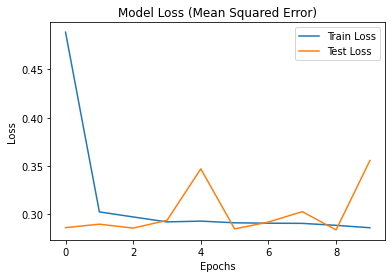

In [ ]:
draw_plots(history)

In [ ]:
%%time
pred_train = model_siamese.predict(x_train)
pred_validate = model_siamese.predict(x_validate)
pred_test = model_siamese.predict(x_test)

evaluate_model(pred_train, y_train, "training")
evaluate_model(pred_validate, y_validate, "validation")
evaluate_model(pred_test, y_test, "testing")

Model MSE Loss in training stage: 0.3490113303861441
Model RMSE Loss in training stage: 0.5907718090651788
Model MAE Loss in training stage: 0.45182181066044985

Model MSE Loss in validation stage: 0.355591852594108
Model RMSE Loss in validation stage: 0.5963152292153102
Model MAE Loss in validation stage: 0.45685159545976717

Model MSE Loss in testing stage: 0.3573240610543382
Model RMSE Loss in testing stage: 0.5977658915113325
Model MAE Loss in testing stage: 0.4558279251903172

CPU times: user 44.3 s, sys: 3.66 s, total: 48 s
Wall time: 35.3 s


## **1.c - Model-Based Benchmark**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(analyzer='char')
count_vectorizer.fit(x_train['product_title'].tolist() + x_train['search_term'].tolist() + x_test['product_title'].tolist() + x_test['search_term'].tolist())

CountVectorizer(analyzer='char', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.2)

In [ ]:
x_train['search_term'] = count_vectorizer.transform(x_train['search_term']).toarray()
x_train['product_title'] = count_vectorizer.transform(x_train['product_title']).toarray()

x_validate['search_term'] = count_vectorizer.transform(x_validate['search_term']).toarray()
x_validate['product_title'] = count_vectorizer.transform(x_validate['product_title']).toarray()

x_test['search_term'] = count_vectorizer.transform(x_test['search_term']).toarray()
x_test['product_title'] = count_vectorizer.transform(x_test['product_title']).toarray()

In [ ]:
y_train = y_train['relevance']
y_validate = y_validate['relevance']
y_test = y_test['relevance']

In [ ]:
%%time
from sklearn import svm

naive_model = svm.SVR()
naive_model.fit(x_train, y_train)

CPU times: user 2min 33s, sys: 54.3 ms, total: 2min 33s
Wall time: 2min 33s


In [ ]:
%%time
pred_train = naive_model.predict(x_train)
pred_validate = naive_model.predict(x_validate)
pred_test = naive_model.predict(x_test)

evaluate_model(pred_train, y_train, "training")
evaluate_model(pred_validate, y_validate, "validation")
evaluate_model(pred_test, y_test, "testing")


Model MSE Loss in training stage: 0.28567381599933567
Model RMSE Loss in training stage: 0.5344846265322658
Model MAE Loss in training stage: 0.4341492804962552

Model MSE Loss in validation stage: 0.295285938249382
Model RMSE Loss in validation stage: 0.5434021883001411
Model MAE Loss in validation stage: 0.44133414320061093

Model MSE Loss in testing stage: 0.28929693321149924
Model RMSE Loss in testing stage: 0.5378633034624125
Model MAE Loss in testing stage: 0.4360305556999427

CPU times: user 3min 14s, sys: 16.5 ms, total: 3min 14s
Wall time: 3min 14s


## **1.d - Feature Extractor**



In [ ]:
x_train, x_test = convert_strings_to_lists(x_train, x_test)

In [ ]:
x_train, x_test = tokenize_words(x_train, x_test, 80)

In [ ]:
x_train, x_test = padding_sequences(x_train, x_test, 80)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.2)

In [ ]:
x_train = [np.array(x_train['product_title'].tolist()), np.array(x_train['search_term'].tolist())]
x_validate = [np.array(x_validate['product_title'].tolist()), np.array(x_validate['search_term'].tolist())]
x_test = [np.array(x_test['product_title'].tolist()), np.array(x_test['search_term'].tolist())]

In [ ]:
model_siamese = construct_siamese_model()
model_siamese.load_weights(main_url + 'best_model_weights_{}.h5'.format('try'))
feature_extractor_model = Model(inputs=model_siamese.input, outputs=model_siamese.layers[len(model_siamese.layers) - 1].output)

### **Random Forest**

In [ ]:
%%time
from sklearn.ensemble import RandomForestRegressor

random_forest_model = RandomForestRegressor(max_depth=5, random_state=0)
random_forest_model.fit(feature_extractor_model.predict(x_train), y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


CPU times: user 17.7 s, sys: 1.22 s, total: 18.9 s
Wall time: 14.9 s


In [ ]:
pred_train = random_forest_model.predict(feature_extractor_model.predict(x_train))
pred_validate = random_forest_model.predict(feature_extractor_model.predict(x_validate))
pred_test = random_forest_model.predict(feature_extractor_model.predict(x_test))

evaluate_model(pred_train, y_train, "training")
evaluate_model(pred_validate, y_validate, "validation")
evaluate_model(pred_test, y_test, "testing")

Model MSE Loss in training stage: 0.2742419033465368
Model RMSE Loss in training stage: 0.5236811084491562
Model MAE Loss in training stage: 0.4295286090601961

Model MSE Loss in validation stage: 0.2790160247483351
Model RMSE Loss in validation stage: 0.5282196747077252
Model MAE Loss in validation stage: 0.4335954689901303

Model MSE Loss in testing stage: 0.28319340864728815
Model RMSE Loss in testing stage: 0.5321591948348615
Model MAE Loss in testing stage: 0.4363903461930142



### **KNN - K-Nearest Neighbors**

In [ ]:
%%time
from sklearn.neighbors import KNeighborsRegressor

k_neighbors_model = KNeighborsRegressor(n_neighbors=10)
k_neighbors_model.fit(feature_extractor_model.predict(x_train), y_train)

CPU times: user 14.5 s, sys: 1.17 s, total: 15.7 s
Wall time: 11.4 s


In [ ]:
%%time
pred_train = k_neighbors_model.predict(feature_extractor_model.predict(x_train))
pred_validate = k_neighbors_model.predict(feature_extractor_model.predict(x_validate))
pred_test = k_neighbors_model.predict(feature_extractor_model.predict(x_test))

evaluate_model(pred_train, y_train, "training")
evaluate_model(pred_validate, y_validate, "validation")
evaluate_model(pred_test, y_test, "testing")

Model MSE Loss in training stage: 0.21083841444315055
Model RMSE Loss in training stage: 0.4591714434099213
Model MAE Loss in training stage: 0.3683891954837729

Model MSE Loss in validation stage: 0.26366128520318616
Model RMSE Loss in validation stage: 0.5134795859653879
Model MAE Loss in validation stage: 0.41406244093425143

Model MSE Loss in testing stage: 0.3252689523677799
Model RMSE Loss in testing stage: 0.5703235505989385
Model MAE Loss in testing stage: 0.46046201825693556

CPU times: user 45.3 s, sys: 3.77 s, total: 49.1 s
Wall time: 35.8 s


# **2 - Word level LSTM**

In [ ]:
!pip install transformers[tf-cpu]

     |████████████████████████████████| 1.5MB 12.6MB/s 
     |████████████████████████████████| 890kB 46.6MB/s 
     |████████████████████████████████| 2.9MB 45.8MB/s 
     |████████████████████████████████| 102kB 11.6MB/s 
     |████████████████████████████████| 71kB 9.5MB/s 
     |████████████████████████████████| 144.5MB 92kB/s 
     |████████████████████████████████| 7.7MB 56.7MB/s 
     |████████████████████████████████| 81kB 12.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=040dc6e506b31f0b4a7e28de48d6c98d6b213460dbdb3c95b458b4f578c03d9a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
  Created wheel for fire: filename=fire-0.3.1-py2.py3-none-any.whl size=111006 sha256=b336a6d3fde8f99b6b6f9ac76b3690917e45cc93f825faf3e1b7cc5ac8fc84cb
  Stored in directory: /root/.cache/pip/wheels/c1/61/df/768b03527bf006b546dce284eb4249b185669e65afc5fbb2ac
Successfully built sacremoses

In [ ]:
from transformers import AutoTokenizer

In [ ]:
from tqdm._tqdm_notebook import tqdm_notebook
import pandas as pd
tqdm_notebook.pandas()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  """Entry point for launching an IPython kernel.


## **2.a - Preprocess the Data**

we'll try to use the product description with the product title

In [ ]:
train_data = pd.read_csv(main_url+"train.csv",sep=',' ,encoding='latin-1')
test_data = pd.read_csv(main_url+"test.csv",sep=',' ,encoding='latin-1')
sol_data = pd.read_csv(main_url+"solution.csv")
description_data = pd.read_csv(main_url+"product_descriptions.csv")
test_data = pd.merge(test_data, sol_data[["id", "relevance"]], on='id')
test_data = test_data[test_data['relevance'] >= 1]
test_data = test_data[test_data['relevance'] <= 3]


In [ ]:
train_data = train_data.merge(description_data, on='product_uid', how='left')
train_data.product_title = train_data.product_title + " " + train_data.product_description

test_data = test_data.merge(description_data, on='product_uid', how='left')
test_data.product_title = test_data.product_title + " " + test_data.product_description

## **2.b - Build Word Embedding**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased",return_tensors="tf",max_length=512)

In [ ]:
train_data['product_title']=train_data['product_title'].astype(str).progress_apply(lambda x: tokenizer(x, padding=True).input_ids)
train_data['search_term']=train_data['search_term'].astype(str).progress_apply(lambda x: tokenizer(x, padding=True).input_ids)

test_data['product_title']=test_data['product_title'].astype(str).progress_apply(lambda x: tokenizer(x, padding=True).input_ids)
test_data['search_term']=test_data['search_term'].astype(str).progress_apply(lambda x: tokenizer(x, padding=True).input_ids)

In [ ]:
test_data

,id,product_uid,product_title,search_term,relevance,product_description
0,4,100001,"[101, 9304, 2844, 1011, 5495, 2260, 1011, 7633...","[101, 3384, 1048, 19719, 102]",2.33,"Not only do angles make joints stronger, they ..."
1,5,100001,"[101, 9304, 2844, 1011, 5495, 2260, 1011, 7633...","[101, 9304, 15315, 2226, 2583, 102]",2.33,"Not only do angles make joints stronger, they ..."
2,6,100001,"[101, 9304, 2844, 1011, 5495, 2260, 1011, 7633...","[101, 9304, 2844, 7208, 102]",2.67,"Not only do angles make joints stronger, they ..."
3,7,100001,"[101, 9304, 2844, 1011, 5495, 2260, 1011, 7633...","[101, 9304, 2844, 5495, 16731, 2278, 28756, 26...",2.00,"Not only do angles make joints stronger, they ..."
4,10,100003,"[101, 10933, 7241, 3943, 1011, 1015, 1013, 101...","[101, 7198, 1998, 6457, 8934, 102]",2.67,Classic architecture meets contemporary design...
...,...,...,...,...,...,...
112062,221467,206644,"[101, 4098, 1014, 1011, 7633, 3565, 4412, 2121...","[101, 4412, 13774, 2075, 3282, 102]",2.33,The CN445R2 is the latest version of the MAX S...
112063,221468,206645,"[101, 24665, 11631, 2063, 3203, 25148, 1017, 4...","[101, 3829, 4013, 24665, 5833, 102]",1.00,The GROHE Ladylux 3 Pro Single-Handle Pull-Out...
112064,221469,206646,"[101, 3438, 1999, 1012, 1060, 2382, 1999, 1012...","[101, 14090, 23615, 2382, 1060, 3438, 2813, 59...",2.67,The Tile Kit bathtub wall set has a tile-like ...
112065,221470,206647,"[101, 7057, 3117, 7368, 3057, 2210, 5061, 4615...","[101, 2422, 6942, 14028, 2005, 2210, 3057, 102]",1.00,Your daughter will be a queen ready to cast he...


In [ ]:
train_data

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,"[101, 9304, 2844, 1011, 5495, 2260, 1011, 7633...","[101, 6466, 21605, 102]",3.00,"Not only do angles make joints stronger, they ..."
1,3,100001,"[101, 9304, 2844, 1011, 5495, 2260, 1011, 7633...","[101, 1048, 21605, 102]",2.50,"Not only do angles make joints stronger, they ..."
2,9,100002,"[101, 2022, 8093, 12882, 14902, 2094, 5877, 78...","[101, 5877, 2058, 102]",3.00,BEHR Premium Textured DECKOVER is an innovativ...
3,16,100005,"[101, 7160, 2310, 3217, 1015, 1011, 5047, 6457...","[101, 4542, 6457, 2132, 102]",2.33,Update your bathroom with the Delta Vero Singl...
4,17,100005,"[101, 7160, 2310, 3217, 1015, 1011, 5047, 6457...","[101, 6457, 2069, 6904, 18796, 2102, 102]",2.67,Update your bathroom with the Delta Vero Singl...
...,...,...,...,...,...,...
74062,221457,206638,"[101, 4448, 3332, 9739, 2063, 5401, 2575, 3729...","[101, 2694, 4125, 2099, 3221, 102]",1.00,"Atlantic, Inc. 94835722 Uniquely designed for ..."
74063,221458,206639,"[101, 19087, 2871, 1011, 15231, 17201, 6914, 1...","[101, 1054, 11387, 17201, 6914, 2422, 102]",3.00,Philips Energy Advantage lamps use less energy...
74064,221463,206641,"[101, 8040, 7317, 4270, 19130, 4140, 1999, 101...","[101, 8040, 7317, 4270, 5843, 23754, 2431, 243...",2.33,The Schlage Camelot In-Active Aged Bronze Hand...
74065,221471,206648,"[101, 20228, 14083, 8586, 2340, 1999, 1012, 10...","[101, 16729, 3871, 25545, 102]",3.00,The Rose Garden is inspired by the popular ear...


In [ ]:
x_train, x_test = padding_sequences(train_data, test_data, 512)

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.00,"Not only do angles make joints stronger, they ..."
1,3,100001,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.50,"Not only do angles make joints stronger, they ..."
2,9,100002,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.00,BEHR Premium Textured DECKOVER is an innovativ...
3,16,100005,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.33,Update your bathroom with the Delta Vero Singl...
4,17,100005,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.67,Update your bathroom with the Delta Vero Singl...


,id,product_uid,product_title,search_term,relevance,product_description
0,4,100001,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.33,"Not only do angles make joints stronger, they ..."
1,5,100001,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.33,"Not only do angles make joints stronger, they ..."
2,6,100001,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.67,"Not only do angles make joints stronger, they ..."
3,7,100001,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.00,"Not only do angles make joints stronger, they ..."
4,10,100003,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.67,Classic architecture meets contemporary design...


In [ ]:
y_train = train_data['relevance']
y_test = test_data['relevance']

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.2)

In [ ]:
x_train = [np.array(x_train['product_title'].tolist()), np.array(x_train['search_term'].tolist())]
x_validate = [np.array(x_validate['product_title'].tolist()), np.array(x_validate['search_term'].tolist())]
x_test = [np.array(x_test['product_title'].tolist()), np.array(x_test['search_term'].tolist())]


## **2.c - Siamese Neural Network**

In [ ]:
model_siamese = construct_siamese_model(512,30522)
model_siamese.summary()
model_siamese.compile(loss='mse', optimizer=RMSprop(learning_rate=0.01))

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 512)]        0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 512, 174)     5310828     input_9[0][0]                    
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 512, 174)     5310828     input_10[0][0]                   
____________________________________________________________________________________________

In [ ]:
%%time
history = model_siamese.fit([x_train[0],x_train[1]], y_train, validation_data=(x_validate, y_validate), epochs=10, batch_size=32, callbacks=set_callbacks(description = "word_siamense"))

Epoch 1/10
1852/1852 [==============================] - 198s 106ms/step - loss: 59.4141 - val_loss: 0.3605
Epoch 2/10
1852/1852 [==============================] - 191s 103ms/step - loss: 0.7451 - val_loss: 0.3470
Epoch 3/10
1852/1852 [==============================] - 191s 103ms/step - loss: 0.7360 - val_loss: 0.2924
Epoch 4/10
1852/1852 [==============================] - 193s 104ms/step - loss: 2.5025 - val_loss: 0.2940
Epoch 5/10
1852/1852 [==============================] - 192s 103ms/step - loss: 1.5585 - val_loss: 0.4671
Epoch 6/10
1852/1852 [==============================] - 192s 104ms/step - loss: 1.5098 - val_loss: 0.3089
Epoch 7/10
1852/1852 [==============================] - 192s 104ms/step - loss: 1.8147 - val_loss: 0.3595
Epoch 8/10
1852/1852 [==============================] - 191s 103ms/step - loss: 1.6814 - val_loss: 1.6721
Epoch 9/10
1852/1852 [==============================] - 193s 104ms/step - loss: 1.8676 - val_loss: 0.3032
Epoch 10/10
1852/1852 [======================

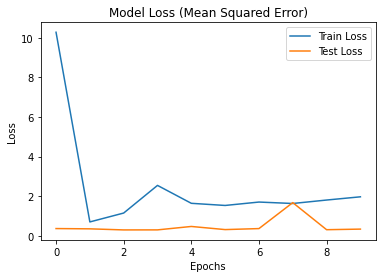

In [ ]:
draw_plots(history)

In [ ]:
%%time
pred_train = model_siamese.predict(x_train)
pred_validate = model_siamese.predict(x_validate)
pred_test = model_siamese.predict(x_test)

evaluate_model(pred_train, y_train, "training")
evaluate_model(pred_validate, y_validate, "validation")
evaluate_model(pred_test, y_test, "testing")

Model MSE Loss in training stage: 0.33107421680618326
Model RMSE Loss in training stage: 0.5753904907158123
Model MAE Loss in training stage: 0.45251095853278306

Model MSE Loss in validation stage: 0.33309087301372436
Model RMSE Loss in validation stage: 0.5771402541962607
Model MAE Loss in validation stage: 0.454474730137889

Model MSE Loss in testing stage: 0.33437002468187266
Model RMSE Loss in testing stage: 0.5782473732598122
Model MAE Loss in testing stage: 0.45345793752717006

CPU times: user 2min 57s, sys: 4.04 s, total: 3min 1s
Wall time: 2min 40s


## **2.d - Feature Extractor**


In [ ]:
model_siamese = construct_siamese_model(512,30522)
model_siamese.load_weights(main_url + 'best_model_weights_{}.h5'.format("word_siamense"))
feature_extractor_model = Model(inputs=model_siamese.input, outputs=model_siamese.layers[len(model_siamese.layers) - 1].output)

### **Random Forest**

In [ ]:
%%time
from sklearn.ensemble import RandomForestRegressor

random_forest_model = RandomForestRegressor(max_depth=5, random_state=0)
random_forest_model.fit(feature_extractor_model.predict(x_train), y_train)

CPU times: user 56.3 s, sys: 1.35 s, total: 57.7 s
Wall time: 51.5 s


In [ ]:
%%time
pred_train = random_forest_model.predict(feature_extractor_model.predict(x_train))
pred_validate = random_forest_model.predict(feature_extractor_model.predict(x_validate))
pred_test = random_forest_model.predict(feature_extractor_model.predict(x_test))

evaluate_model(pred_train, y_train, "training")
evaluate_model(pred_validate, y_validate, "validation")
evaluate_model(pred_test, y_test, "testing")

Model MSE Loss in training stage: 0.28345228698105307
Model RMSE Loss in training stage: 0.5324023731925441
Model MAE Loss in training stage: 0.43621475715963326

Model MSE Loss in validation stage: 0.2861693842338098
Model RMSE Loss in validation stage: 0.534948020123273
Model MAE Loss in validation stage: 0.4388157115373447

Model MSE Loss in testing stage: 0.28666521931420397
Model RMSE Loss in testing stage: 0.5354112618485009
Model MAE Loss in testing stage: 0.4386784263289731

CPU times: user 3min, sys: 4.11 s, total: 3min 4s
Wall time: 2min 42s


### **XGBoost**

In [ ]:
import xgboost as xgb

In [ ]:
%%time
param = {'max_depth':7}
num_round = 24
xg_train = xgb.DMatrix(feature_extractor_model.predict(x_train), label=y_train)
clf = xgb.train( param, xg_train, num_round)

CPU times: user 59.8 s, sys: 1.29 s, total: 1min 1s
Wall time: 54.1 s


In [ ]:
%%time
pred_train = clf.predict(xgb.DMatrix(feature_extractor_model.predict(x_train)))
pred_validate = clf.predict(xgb.DMatrix(feature_extractor_model.predict(x_validate)))
pred_test = clf.predict(xgb.DMatrix(feature_extractor_model.predict(x_test)))

evaluate_model(pred_train, y_train, "training")
evaluate_model(pred_validate, y_validate, "validation")
evaluate_model(pred_test, y_test, "testing")

Model MSE Loss in training stage: 0.28206781331253716
Model RMSE Loss in training stage: 0.5311005679836326
Model MAE Loss in training stage: 0.4348784134526507

Model MSE Loss in validation stage: 0.285999370069196
Model RMSE Loss in validation stage: 0.534789089332604
Model MAE Loss in validation stage: 0.43870868631456644

Model MSE Loss in testing stage: 0.2871447084809795
Model RMSE Loss in testing stage: 0.5358588512668047
Model MAE Loss in testing stage: 0.4388913719565603

CPU times: user 3min 7s, sys: 4.12 s, total: 3min 11s
Wall time: 2min 47s


# **3 - Result table**

In [ ]:
columns = ['Runtime','Train-RMSE','Val-RMSE','Test-RMSE','Train-MAE','Val-MAE','Test-MAE']
result = {}

result['Naïve Benchmark'] = ['5min 47sec',0.5344,0.5434,0.5378,0.4341,0.4413,0.4360]
result['Character Level LSTM']=['7min 32sec',0.5280,0.5318,0.5352,0.4351,0.4389,0.4412]
result['Character Level Random Forest']=['18.9sec',0.5236,0.5282,0.5321,0.4295,0.4335,0.4363]
result['Character Level KNN']=['15.7sec',0.4591,0.5134,0.5703,0.3683,0.4140,0.4604]
result['Word Level LSTM']=['42min 5sec',0.5753,0.5771,0.5782,0.4525,0.4544,0.4534]
result['Word Level Random Forest']=['57.7sec',0.5324,0.5354,0.5321,0.4362,0.4388,0.4386]
result['Word Level XGBoost']=['1min 1sec',0.5311,0.5347,0.5358,0.4348,0.4387,0.4388]

pd.DataFrame.from_dict(result, orient='index',columns=columns)

,Runtime,Train-RMSE,Val-RMSE,Test-RMSE,Train-MAE,Val-MAE,Test-MAE
Naïve Benchmark,5min 47sec,0.5344,0.5434,0.5378,0.4341,0.4413,0.4360
Character Level LSTM,7min 32sec,0.5280,0.5318,0.5352,0.4351,0.4389,0.4412
Character Level Random Forest,18.9sec,0.5236,0.5282,0.5321,0.4295,0.4335,0.4363
Character Level KNN,15.7sec,0.4591,0.5134,0.5703,0.3683,0.4140,0.4604
Word Level LSTM,42min 5sec,0.5753,0.5771,0.5782,0.4525,0.4544,0.4534
Word Level Random Forest,57.7sec,0.5324,0.5354,0.5321,0.4362,0.4388,0.4386
Word Level XGBoost,1min 1sec,0.5311,0.5347,0.5358,0.4348,0.4387,0.4388
